In [2]:
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

Define Paths

In [3]:
processed_data_dir = "../data/processed"
output_data_dir = "../data/outputs"

os.makedirs(output_data_dir, exist_ok=True)

Load/Align Rasters Helper Function

In [4]:
def load_and_align_rasters(file_list, reference_raster=None):
    """
    Loads a list of rasters and aligns them to a common resolution/extent.
    If reference_raster is provided, aligns all to that raster.
    Returns an xarray.Dataset with all rasters stacked as variables.
    """
    rasters = []
    names = []

    for file in file_list:
        arr = rxr.open_rasterio(file, masked=True).squeeze()
        names.append(os.path.splitext(os.path.basename(file))[0])

        # Reproject/align if reference is given
        if reference_raster is not None:
            arr = arr.rio.reproject_match(reference_raster)

        rasters.append(arr)

    # Stack into dataset
    ds = xr.merge([rasters[i].to_dataset(name=names[i]) for i in range(len(rasters))])
    return ds

Severity Classification Function

In [5]:
def classify_severity(dnbr):
    if dnbr < 0.1:
        return "Unburned"
    elif dnbr < 0.27:
        return "Low"
    elif dnbr < 0.44:
        return "Moderate"
    else:
        return "High"

Process All Fires

In [6]:
all_fire_dfs = []

# Detect fires based on available files
fires = sorted(set(os.path.basename(f).split("_")[0] for f in glob(os.path.join(processed_data_dir, "*.tif"))))

for fire_name in fires:
    print(f"Processing {fire_name} fire ...")

    fire_files = glob(os.path.join(processed_data_dir, f"{fire_name}_*.tif"))
    dnbr_path = os.path.join(processed_data_dir, f"{fire_name}_dNBR.tif")

    if not os.path.exists(dnbr_path):
        print(f"Skipping {fire_name} — no dNBR available.")
        continue

    try:
        reference = rxr.open_rasterio(dnbr_path, masked=True).squeeze()
        fire_ds = load_and_align_rasters(fire_files, reference_raster=reference)

        # Mask no-data areas based on dNBR
        fire_ds = fire_ds.where(~np.isnan(fire_ds[f"{fire_name}_dNBR"]), drop=True)

        # Convert to dataframe
        df = fire_ds.to_dataframe().reset_index()
        df = df.dropna()
        df["fire_name"] = fire_name
        df["severity"] = df[f"{fire_name}_dNBR"].apply(classify_severity)

        # Save individual file
        fire_output = os.path.join(output_data_dir, f"{fire_name}_dataset.parquet")
        df.to_parquet(fire_output, index=False)
        print(f"Saved {fire_name} dataset with {len(df)} pixels → {fire_output}")

        all_fire_dfs.append(df)

    except Exception as e:
        print(f"Error processing {fire_name}: {e}")



Processing Bootleg fire ...
Skipping Bootleg — no dNBR available.
Processing Caldor fire ...


C:\Users\johnm\AppData\Local\Temp\ipykernel_2944\1609434101.py:21: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([rasters[i].to_dataset(name=names[i]) for i in range(len(rasters))])


Saved Caldor dataset with 5517951 pixels → ../data/outputs\Caldor_dataset.parquet
Processing Camp fire ...


C:\Users\johnm\AppData\Local\Temp\ipykernel_2944\1609434101.py:21: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([rasters[i].to_dataset(name=names[i]) for i in range(len(rasters))])


Saved Camp dataset with 4412816 pixels → ../data/outputs\Camp_dataset.parquet
Processing Dixie fire ...


C:\Users\johnm\AppData\Local\Temp\ipykernel_2944\1609434101.py:21: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([rasters[i].to_dataset(name=names[i]) for i in range(len(rasters))])


Saved Dixie dataset with 5625635 pixels → ../data/outputs\Dixie_dataset.parquet
Processing Troublesome fire ...


C:\Users\johnm\AppData\Local\Temp\ipykernel_2944\1609434101.py:21: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([rasters[i].to_dataset(name=names[i]) for i in range(len(rasters))])


Saved Troublesome dataset with 5576320 pixels → ../data/outputs\Troublesome_dataset.parquet


Combine Fires

In [7]:
if all_fire_dfs:
    combined_df = pd.concat(all_fire_dfs, ignore_index=True)
    combined_output = os.path.join(output_data_dir, "combined_dataset.parquet")
    combined_df.to_parquet(combined_output, index=False)
    print(f"\nCombined dataset saved → {combined_output}")
    print(f"Total pixels across all fires: {len(combined_df)}")
else:
    print("No fires were successfully processed.")


Combined dataset saved → ../data/outputs\combined_dataset.parquet
Total pixels across all fires: 21132722


Visualization

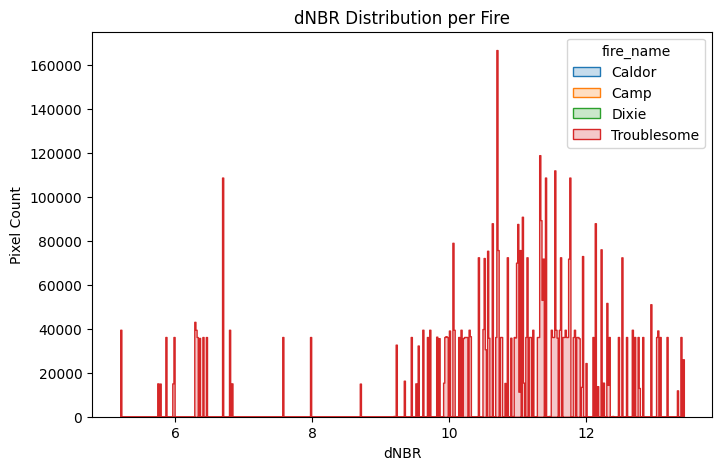

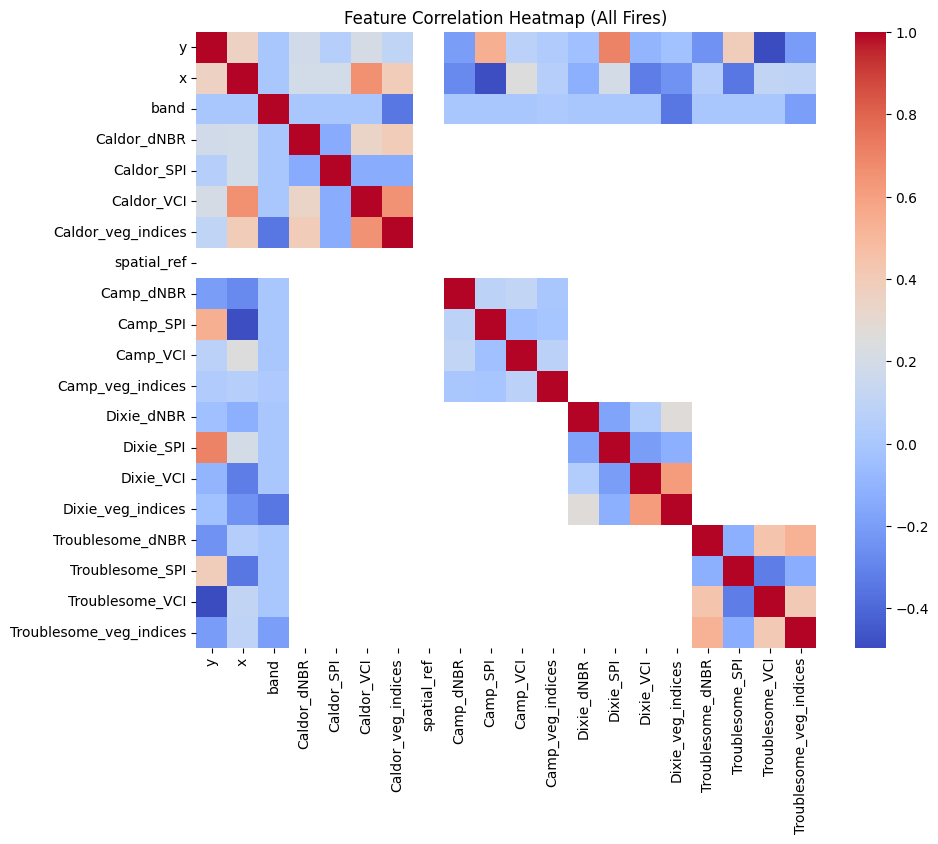

In [8]:
if all_fire_dfs:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=combined_df, x="Bootleg_dNBR" if "Bootleg_dNBR" in combined_df.columns else combined_df.columns[-3],
                 hue="fire_name", element="step", common_norm=False)
    plt.title("dNBR Distribution per Fire")
    plt.xlabel("dNBR")
    plt.ylabel("Pixel Count")
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(combined_df.corr(numeric_only=True), cmap="coolwarm", annot=False)
    plt.title("Feature Correlation Heatmap (All Fires)")
    plt.show()